In [1]:
# import libraries
# import fastai
from fastai import *
from fastai.text import * 
import numpy as np
from functools import partial
import io,os,zipfile,torch,random,fastai
# import os
from sklearn.model_selection import train_test_split
import pandas as pd
# import zipfile
# import torch
# import random
z= zipfile.ZipFile('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')
z.extractall()

In [2]:
data=pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip').head(1000)
data['toxic'].value_counts()

0    895
1    105
Name: toxic, dtype: int64

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
random_seed(1324, False)

In [5]:
fastai.__version__

'2.6.3'

In [6]:
# !pip install fastai==1.0.57
# fastai.__version__

In [7]:
df_trn, df_val = train_test_split(data[['comment_text','toxic']], test_size = 0.3)# stratify = data['Theme_OG'],

In [8]:
import fastai
from fastai.text import *
# from fastai.callbacks import *
from fastai.text.all import LMDataLoader
from fastai.text.all import *

In [11]:
data_lm = TextDataLoaders.from_df( df_trn,text_cols='comment_text',is_lm=True)
data_lm.show_batch()

,text,text_
0,"xxbos xxmaj hi xxmaj xxunk , \n\n xxmaj thanks for taking the time to write such a long message - i appreciate this . \n\n xxmaj in terms of what i said about the age - i did n't mean to cause xxunk . i thought i read somewhere that you had to be over 18 to make these decisions but i think i was getting confused with the check user xxunk","xxmaj hi xxmaj xxunk , \n\n xxmaj thanks for taking the time to write such a long message - i appreciate this . \n\n xxmaj in terms of what i said about the age - i did n't mean to cause xxunk . i thought i read somewhere that you had to be over 18 to make these decisions but i think i was getting confused with the check user xxunk ."
1,"of non - mentions in a non - reliable source ( pretty much "" "" i discussed the topic with them "" "" in a college magazine interview ) \n▁ 1 is local press coverage of his xxunk that 's not even "" "" news for a day "" "" or evidence of anything beyond "" "" a course by this name is xxunk xxunk xxunk in our local village xxunk ""","non - mentions in a non - reliable source ( pretty much "" "" i discussed the topic with them "" "" in a college magazine interview ) \n▁ 1 is local press coverage of his xxunk that 's not even "" "" news for a day "" "" or evidence of anything beyond "" "" a course by this name is xxunk xxunk xxunk in our local village xxunk "" """
2,"among xxunk in xxmaj new xxmaj york xxmaj post . xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk ( may her rest in xxunk , although i know she is xxunk in xxunk other xxunk are the ones who make a great company for xxmaj amir xxmaj taheri . xxmaj this guy has no mind at all . i agree that xxmaj xxunk 's regime is","xxunk in xxmaj new xxmaj york xxmaj post . xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk ( may her rest in xxunk , although i know she is xxunk in xxunk other xxunk are the ones who make a great company for xxmaj amir xxmaj taheri . xxmaj this guy has no mind at all . i agree that xxmaj xxunk 's regime is wrong"
3,"hi . xxmaj i 'm sorry to jump on your contribution the moment you put it in , but the trouble is , it is simply not the sort of thing xxmaj wikipedia is for . xxmaj these links are all in one or other of the template xxunk above , but to put them all in one place , the reasons your article is being xxunk for deletion are : \n",". xxmaj i 'm sorry to jump on your contribution the moment you put it in , but the trouble is , it is simply not the sort of thing xxmaj wikipedia is for . xxmaj these links are all in one or other of the template xxunk above , but to put them all in one place , the reasons your article is being xxunk for deletion are : \n xxmaj"
4,"should have done in the first place . xxmaj if you are not willing or able to do this today , xxmaj i 'll ask a another administrator to do it . xxbos xxmaj thank you \n xxmaj xxunk , it 's me , the xxmaj william xxmaj hope fan . xxmaj guess what - i am back at a new xxup ip , xxunk to vandalize everything regarding xxmaj william xxmaj","have done in the first place . xxmaj if you are not willing or able to do this today , xxmaj i 'll ask a another administrator to do it . xxbos xxmaj thank you \n xxmaj xxunk , it 's me , the xxmaj william xxmaj hope fan . xxmaj guess what - i am back at a new xxup ip , xxunk to vandalize everything regarding xxmaj william xxmaj hope"
5,""" xxbos xxmaj he is , self - xxunk , and xxunk by my xxunk ( see , e.g. , history of xxmaj soviet partisan ) . xxup btw , you 're the first to xxunk ) . xxbos "" \n\n xxmaj what chart are you looking at ? i do n't see anything xxunk that xxunk . [ [ user talk : xxunk ] ] xxrep 3 ' "" xxbos ""","xxbos xxmaj he is , self - xxunk , and xxunk by my xxunk ( see , e.g. , history of xxmaj soviet partisan ) . xxup btw , you 're the first to xxunk ) . xxbos "" \n\n xxmaj what chart are you looking at ? i do n't see anything xxunk that xxunk . [ [ user talk : xxunk ] ] xxrep 3 ' "" xxbos "" the

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM,metrics=[accuracy], drop_mult=0.3)

SuggestedLRs(valley=0.005248074419796467)

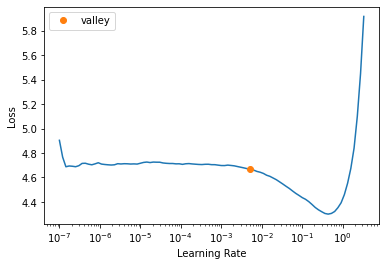

In [13]:
learn.lr_find()

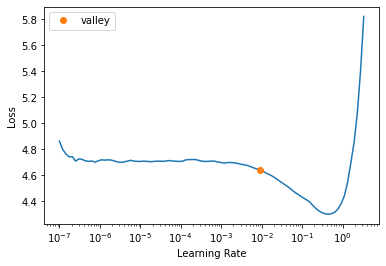

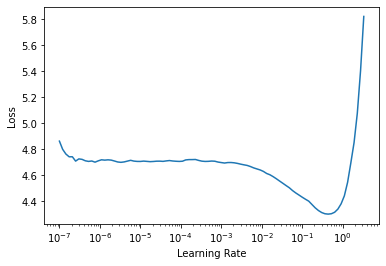

In [16]:
# learn.recorder.pl(suggestion=True)
# min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr = learn.recorder.lr

learn.lr_find();
learn.recorder.plot_lr_find();

In [17]:
learn.recorder.lr

0.001

In [18]:
learn.fit_one_cycle(5, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.686386,4.310878,0.264232,00:03
1,4.628360,4.217381,0.271394,00:03
2,4.555939,4.161527,0.275590,00:03
3,4.495432,4.138419,0.276421,00:03
4,4.460190,4.134524,0.276711,00:03


In [20]:
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(20,  5e-4, moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.334400,4.042429,0.286838,00:03
1,4.263238,3.923656,0.299316,00:03
2,4.166261,3.817492,0.310927,00:03
3,4.062360,3.757600,0.319499,00:03
4,3.954707,3.724155,0.320150,00:03
5,3.835618,3.703454,0.323550,00:03
6,3.712717,3.700887,0.321072,00:03
7,3.577901,3.729133,0.317509,00:03
8,3.431071,3.764867,0.312482,00:03
9,3.281669,3.786336,0.310836,00:03


In [21]:
learn.predict("username", n_words=10)

'username is warning your actions on how i develop skills .'

In [22]:
learn.save_encoder('ft_enc_v2')

In [23]:
# df_trn['is_valid']=False
# df_val['is_valid']=True
# df=pd.concat([df_trn,df_val])
# df.shape

In [ ]:
# # Make a list of columns that would serve as your labels for this task
# label_cols = list(train_df.columns[2:])

# # Create a column of texts which has a list of all the categories.
# # When all the entries are zeros, let's call the txt sober
# def get_labels(row):
#     indcs = np.where(row == 1)[0]
#     if len(indcs) == 0:
#         return "sober"
#     return ";".join([label_cols[x] for x in indcs])
    
# # Get the labels all in a nicely formatted style
# labels = train_df[label_cols].apply(lambda row: get_labels(row), axis = 1)

# # Add the labels object to our dataframe
# train_df["Labels"] = labels

In [28]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Create a Dataloader to feed to the model
dls_blk = DataBlock(blocks = (TextBlock.from_df(text_cols = "comment_text", seq_len = 128),
                              CategoryBlock),
                    get_x = ColReader(cols = "text"),
                    get_y = ColReader(cols = "toxic"),
                    splitter = TrainTestSplitter(test_size = 0.2, random_state = 21))
#, label_delim = ";"
dls_clf = dls_blk.dataloaders(df_trn,seed = 20)

In [65]:
df_trn.shape[0]

(700, 2)

In [37]:
dls_clf.show_batch()

,text,category
0,"xxbos xxmaj xxunk , xxmaj hello xxmaj witzeman \n\n xxunk \n xxmaj xxunk : ~ | xxunk xxunk xxunk xxunk xxunk xxunk xxunk • xxunk # xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk ‘ “ ’ ” xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk $ xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk ♠ ♣ ♥ ♦ xxunk xxunk \n xxmaj characters : xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk",0
1,"xxbos "" \n\n xxmaj xxunk \n\n xxup please xxup do xxup not xxup edit xxup below xxup this xxup note . xxup the xxup whole xxup xxunk - section xxup will xxup disappear xxup again xxup once i xxup am xxup able xxup to xxup post xxup on xxup the xxup article xxup talk xxup page . \n\n xxmaj this includes you xxmaj xxunk . xxmaj had you not blocked me , i would have been able to place my answers there . xxmaj this will disappear tomorrow so you can put with it until then . \n\n xxmaj because xxmaj xxunk falsely blocked me , i can not save my xxunk on a certain article talk page . xxmaj hence i will save the entire page ( xxunk the xxunk sections ) here . \n\n▁ xxup pov concerns \n\n xxmaj i m surprised this article is n't being called",0
2,"xxbos "" \n\n xxunk 's xxunk \n\n xxmaj presently , we are xxunk an open war against xxmaj croatian xxmaj dinaric culture . xxmaj croatian xxmaj left often xxunk this culture as "" "" xxunk "" "" and "" "" xxunk "" "" ( even "" "" xxunk "" "" ) being in service of xxmaj xxunk xxup xxunk party . xxmaj croatian writer xxmaj xxunk xxmaj xxunk , for instance , "" "" xxunk "" "" on gusle instrument in xxmaj xxunk on several xxunk this year ( 2004 ) with only one intention - to xxunk the same instrument and its xxunk xxunk tradition . \n▁\n xxmaj another "" "" xxunk "" "" of xxmaj croatian xxmaj left - xxmaj xxunk xxmaj xxunk - refers to his political xxunk on the xxmaj right as "" "" gusle players "" "" . \n\n xxmaj some even claim the xxmaj",0
3,"xxbos "" \n\n▁ xxmaj question on xxmaj possible xxmaj citation \n\n xxmaj i 'm sorry if i missed your question - i do n't pay much attention to that page . xxmaj in response to your question , let me start by xxunk my xxunk xxunk : xxmaj the job of xxmaj wikipedia editors is to verifiably summarize reliable sources using the neutral point of view . ( i have n't yet worked in "" "" no original research "" "" . ) xxup wp : nor says that we must n't xxunk otherwise reliable information to xxunk at xxunk conclusions . xxmaj xxunk two lists and xxunk conclusions from their differences and xxunk is most likely original research . xxmaj we can xxunk information , so long as we do n't xxunk at new theories . xxmaj another principle to remember is that xxunk xxunk accuracy . xxmaj the",0
4,"xxbos "" \n\n▁ wikipedia : articles for deletion / xxmaj xxunk xxmaj xxunk \n\n xxmaj your post at the above xxup afd on a new martial art xxunk me . xxmaj this was the version at the time , that you based your post on . xxmaj you posted : \n\n▁ "" "" i just read the article , and to be quite honest , feel that it does xxunk xxmaj wikipedia 's guidelines … it is reliably sourced … xxmaj since i believe the notability of the article is xxunk … xxmaj it now has 11 independent sources . xxmaj and to xxunk the argument xxunk by xxmaj xxunk , it is xxunk by the xxmaj xxunk xxmaj xxunk source that the martial xxunk is not xxunk "" "" . \n\n xxmaj please consider the concerns this post xxunk . xxmaj simple matters like references , notability and xxunk",0
5,"xxbos "" \n\n▁ xxmaj randroide xxmaj answers to "" "" next xxmaj xxunk "" "" \n\n 

In [57]:
dls_clf

In [31]:
# Text Classifier
learn_clf = text_classifier_learner(dls_clf, 
                                    # Specify a model architecture for the learner
                                    AWD_LSTM, 
                                    # Specify the % in dropout layer for regularization
                                    drop_mult=0.5,
                                    # Specify a metric to evaluate performance while training
                                    metrics = accuracy).to_fp16()

# Load the embeddings from the finetuned language model in our learner object
learn_clf = learn_clf.load_encoder("ft_enc_v2")

In [33]:
# # Text Classifier
# # data_clas = TextClasDataBunch.from_df(train_df=df_trn,valid_df=df_val,path ="",text_cols=0,label_cols=1,bs=32,vocab=data_lm.vocab)
# data_clas.vocab = data_lm.vocab
# config = awd_lstm_clas_config.copy()
# learn_1 = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5)
# # len(data_clas.vocab.itos) == len(data_lm.vocab.itos)
# data_clas.vocab == data_lm.vocab
# learn_1.load_encoder('ft_enc_v2')

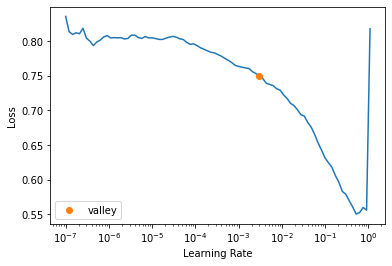

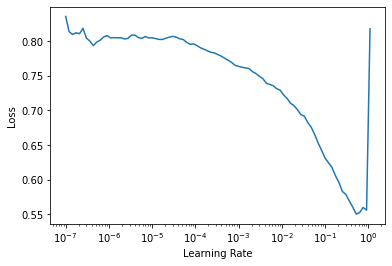

In [36]:
learn_clf.lr_find()
learn_clf.recorder.plot_lr_find(suggestion=True)
# min_grad_lr = learn_clf.recorder.min_grad_lr
min_grad_lr = learn_clf.recorder.lr

In [38]:
learn_clf.fit_one_cycle(5, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.767640,0.629789,0.850000,00:02
1,0.718954,0.644894,0.678571,00:02
2,0.683275,0.627702,0.714286,00:02
3,0.656935,0.634370,0.700000,00:02
4,0.636613,0.632534,0.714286,00:02


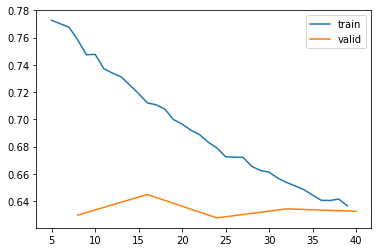

In [40]:
learn_clf.recorder.plot_loss()

In [41]:
learn_clf.freeze_to(-2)
learn_clf.fit_one_cycle(5, 5e-3, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.616872,1.037589,0.464286,00:02
1,0.597785,0.402670,0.914286,00:02
2,0.558102,0.411288,0.914286,00:02
3,0.505323,0.418905,0.928571,00:02
4,0.455117,0.462215,0.871429,00:02


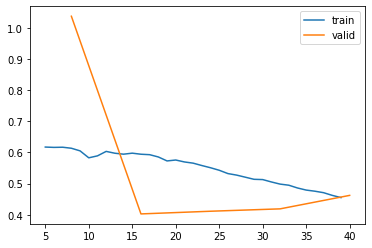

In [44]:
learn_clf.recorder.plot_loss()

In [45]:
learn_clf.unfreeze()
learn_clf.fit_one_cycle(20, 5e-3, moms=(0.8,0.7,0.8))
# slice(2e-3/100, 2e-3),


epoch,train_loss,valid_loss,accuracy,time
0,0.314716,0.401253,0.900000,00:05
1,0.290806,0.391899,0.921429,00:03
2,0.292281,0.293673,0.914286,00:03
3,0.335549,0.338850,0.921429,00:03
4,0.308818,1.520910,0.792857,00:03
5,0.311807,1.706478,0.514286,00:03
6,0.281091,0.658730,0.735714,00:03
7,0.247318,0.223493,0.921429,00:03
8,0.212609,0.380561,0.907143,00:03
9,0.182011,0.339857,0.928571,00:03


In [84]:
len(dls_clf.train_ds)
dls_clf.train_ds[0]

(TensorText([   2,   10,  532,   23,  149,    5,  539,  386,    0,    0,   17,    0,
           80, 1206,    0,    9,   37,  315,    0,  129,   69,   61, 1146,  219]),
 TensorCategory(0))

In [68]:
preds,y,losses = learn_clf.get_preds(with_loss=True, reorder=False )
interp = ClassificationInterpretation(learn_clf,dls_clf,losses)
interp.print_classification_report()

In [64]:
len(np.argmax(preds,1))

140

In [85]:
preds_trn,y_trn,losses_trn = learn_clf.get_preds(dl=dls_clf.train_ds[0] ,with_loss=True, reorder=False)
interp_trn = ClassificationInterpretation(learn_clf,dls_clf.train_ds, losses_trn)
# interp_trn.plot_confusion_matrix()

ValueError: not enough values to unpack (expected 2, got 0)